### Project Chicago: Transform ResStock UPGRADE Results to 15 SFD prototypes (Elevate Energy) - data not available yet
Created on: 12/15/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '03_sfamh' # <----- options: '03_sfamh'
iter_path = f'cookcnty_upgrades_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir,iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Result path: \n   {result_path}')


Result path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_sfamh


### Functions

In [4]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui_thermpersqft'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui_kwhpersqft'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui_kbtupersqft'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
    
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')


func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


### 1. BASELINE results

In [6]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)
res['build_existing_model.sample_weight'] = 2173433/40000

# save a copy at bldg level
if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)

# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

# check
jobs_missing = set(range(1,150)) - set(res.job_id.unique())
print(f'- {len(jobs_missing)} jobs missing: {jobs_missing}')
print(f'- {2464-len(res)} buildings ({((2464-len(res))/2464*100):.2f}%)')

res

- 0 jobs missing: set()
- 0 buildings (0.00%)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft
0,1,127,2021-06-30 16:24:45,2021-06-30 16:28:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.909091,18.272727,336.738017,319.047126,2514.0,395.261388,1202.0,0.445374,4.098216,58.510493
1,2,42,2021-06-30 17:37:14,2021-06-30 17:40:31,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.090909,16.363636,53.244335,67.353566,2155.0,74.409253,866.0,0.873858,7.004861,111.266492
2,3,35,2021-06-30 17:30:28,2021-06-30 17:34:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.000000,17.363636,141.747930,90.600930,4744.0,170.922267,1202.0,0.447165,3.904813,58.029592
3,4,16,2021-06-30 17:17:03,2021-06-30 17:20:28,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.454545,14.363636,247.485970,335.623777,544.0,421.112130,1202.0,0.000000,11.554596,39.425885
4,5,52,2021-06-30 17:36:49,2021-06-30 17:41:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,13.272727,13.909091,257.171182,278.261169,6378.0,376.538900,1675.0,0.288625,5.129941,46.359645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2460,144,2021-06-30 17:07:13,2021-06-30 17:08:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.727273,18.272727,6.247695,8.579762,8561.0,9.477889,1220.0,1.287834,6.335857,150.371562
2460,2461,147,2021-06-30 16:34:47,2021-06-30 16:38:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.727273,18.818182,114.449834,84.151565,3955.0,132.488264,1675.0,0.515859,3.816574,64.596320
2461,2462,111,2021-06-30 16:13:58,2021-06-30 16:17:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.181818,16.363636,47.371967,25.414189,4456.0,52.041861,1202.0,0.876230,4.198847,101.929126
2462,2463,108,2021-06-30 16:42:44,2021-06-30 16:46:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.727273,17.272727,103.731905,79.457145,5005.0,117.615266,1675.0,0.678655,4.002024,81.504774


In [7]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [8]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_upgrades_03_sfamh - BASELINE result summary:

  * 2464 / 2464 samples ran successfully, 0 failed, efficacy: 100.0% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1           0.489854
2           0.455763
3           0.054383
N_failed    0.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry     0.505682
WoodStud    0.494318
N_failed    0.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59     0.136769
1960-79     0.242289
1980-99     0.353896
2000-09     0.164367
2010s       0.014610
<1940       0.088068
N_failed    0.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC    0.807630
Heat Pump     0.025162
None          0.026380
Room AC       0.140828
N_failed      0.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP                   

### 1.2. Add additional metrics to Baseline

In [9]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories
0,1,127,2021-06-30 16:24:45,2021-06-30 16:28:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,336.738017,319.047126,2514.0,395.261388,1202.0,0.445374,4.098216,58.510493,3: post-1978,2: 2+ stories
1,2,42,2021-06-30 17:37:14,2021-06-30 17:40:31,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,53.244335,67.353566,2155.0,74.409253,866.0,0.873858,7.004861,111.266492,2: 1942-1978,1: <2 stories
2,3,35,2021-06-30 17:30:28,2021-06-30 17:34:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,141.747930,90.600930,4744.0,170.922267,1202.0,0.447165,3.904813,58.029592,3: post-1978,2: 2+ stories
3,4,16,2021-06-30 17:17:03,2021-06-30 17:20:28,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,247.485970,335.623777,544.0,421.112130,1202.0,0.000000,11.554596,39.425885,3: post-1978,1: <2 stories
4,5,52,2021-06-30 17:36:49,2021-06-30 17:41:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,257.171182,278.261169,6378.0,376.538900,1675.0,0.288625,5.129941,46.359645,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,2460,144,2021-06-30 17:07:13,2021-06-30 17:08:32,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,6.247695,8.579762,8561.0,9.477889,1220.0,1.287834,6.335857,150.371562,1: pre-1942,1: <2 stories
2460,2461,147,2021-06-30 16:34:47,2021-06-30 16:38:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,114.449834,84.151565,3955.0,132.488264,1675.0,0.515859,3.816574,64.596320,2: 1942-1978,2: 2+ stories
2461,2462,111,2021-06-30 16:13:58,2021-06-30 16:17:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,47.371967,25.414189,4456.0,52.041861,1202.0,0.876230,4.198847,101.929126,3: post-1978,2: 2+ stories
2462,2463,108,2021-06-30 16:42:44,2021-06-30 16:46:40,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,103.731905,79.457145,5005.0,117.615266,1675.0,0.678655,4.002024,81.504774,3: post-1978,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [10]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [11]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [12]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [13]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui_thermpersqft', 
               'median elec eui': 'elec_eui_kwhpersqft'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui_thermpersqft', 
               'mean elec eui': 'elec_eui_kwhpersqft'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Masonry All Years Split Level,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Masonry Post-1978 2 or more stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Masonry 1942-1978 Less than 2 Stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Masonry 1942-1978 2 or more stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Masonry Pre-1942 less than 2 stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Masonry Pre-1942 2 or more stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Frame Post-1978 Less than 2 stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Frame Post-1978 Split Level,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
### export BASELINE prototype summary
groups.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_sfamh/baseline


## 2. UPGRADE results ###

In [15]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(p, ref, HVAC_upgrades_rate_change):
    
    res = ref.set_index('building_id')[['gas_rate', 'gas_fixed', 'gas_CO2_rate',
                                        'elec_rate', 'elec_fixed', 'elec_CO2_rate'
                                       ]]
    ## assign rates
    p['gas_rate'] = p['building_id'].map(res['gas_rate'])
    p['gas_fixed'] = p['building_id'].map(res['gas_fixed'])
    p['gas_CO2_rate'] = p['building_id'].map(res['gas_CO2_rate'])
    p['elec_rate'] = p['building_id'].map(res['elec_rate'])
    p['elec_fixed'] = p['building_id'].map(res['elec_fixed'])
    p['elec_CO2_rate'] = p['building_id'].map(res['elec_CO2_rate'])
    
    if n in HVAC_upgrades_rate_change.keys():
        new_rates = HVAC_upgrades_rate_change[n]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
        
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan
    
    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [16]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 * 12
NGH_fixed = 21.51 * 12
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm


### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    25: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 15 ASHP
    26: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 22 ASHP
    29: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Room AC to Heat Pump
#     32: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Cooling to MSHP
    30: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar 96% AFUE Natural Gas Furnace
    31: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar Natural Gas Boiler
    33: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, High Eff
    34: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, Min Eff
    36: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Electric to MSHP
    37: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Non-electric to MSHP
    38: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, High Eff
    39: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, Min Eff
#     43: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Heating to MSHP
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed
 
# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [32]:
## make dictionary of upgrades paths, for mapping reference scenarios ##

res_partitions = ['03',] # <------
print(f'>>> {iter_path[:]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## get summary table
upgrades_path_df = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}_sfamh'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
            
        ### add to summary table
        summ = pd.DataFrame()
        if not upgrade_name.startswith('Reference') and \
            upgrade_name!='Efficient Pool Pump' and \
            upgrade_name!='Electrify Pool Heating':
            summ.loc[0,'upgrade_no'] = ni
        else:
            summ.loc[0,'upgrade_no'] = np.nan
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'partition'] = part
        summ.loc[0,'partition_upgrade_no'] = n
        upgrades_path_df.append(summ)
        
        if not upgrade_name.startswith('Reference') and \
            upgrade_name!='Efficient Pool Pump' and \
            upgrade_name!='Electrify Pool Heating':
            ni += 1
        
upgrades_path_df = pd.concat(upgrades_path_df, axis=0).reset_index(drop=True).set_index(['upgrade_name'])
print('mapping dictionary:')
pd.set_option('display.max_rows', len(upgrades_path_df))
upgrades_path_df


>>> cookcnty_upgrades_03_sfamh has 1 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_03_sfamh has 74 upgrades
mapping dictionary:


,upgrade_no,partition,partition_upgrade_no
upgrade_name,,,
"Air Leakage 25% Reduction, with Mech Vent under 7 ACH50",1.0,03,1.0
"Air Leakage to 1ACH50, with Mech Vent",2.0,03,2.0
"Attic Insulation, R-49",3.0,03,3.0
"Attic Insulation, R-60",4.0,03,4.0
"Duct Sealing and Insulation to R-8, 10% Leakage",5.0,03,5.0
Low-E Storm Window,6.0,03,6.0
"Low-E Double Pane, High-Gain",7.0,03,7.0
"Low-E Double Pane, Low-Gain",8.0,03,8.0
Reference Roof Replacement,NaN,03,9.0


### 2.1. Get UPGRADE summary

In [42]:
pd.reset_option('display.max_rows')
res_partitions = ['03',] # <------

export_all_upgrades_to_csv = False # <------

print(f'>>> {iter_path} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')    
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)
    

## get summary table
summary_upgrades = []

## initialize dB table
all_proto_upgrades = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}_sfamh'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
        print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')
        if upgrade_name in ['Reference Pool Pump',
                            'Efficient Pool Pump',
                            'Reference Pool Heating',
                            'Electrify Pool Heating']:
            print('Related to pool, skipping...')
            pass
        else:
            p['build_existing_model.sample_weight'] = 2173432/40000

            ### get sim output at unit level
            p = get_per_unit_sim_output_limited(p, res)

            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations')

            ### calculate metrics
            p = add_sqft_eui(p, res)
            EUIi = ['gas_eui_thermpersqft','elec_eui_kwhpersqft','site_eui_kbtupersqft']
            EUIo = ['gas_eui','elec_eui','site_eui']
            for vari, varo in zip(EUIi, EUIo):
                p[f'pct_delta_{varo}'] = ((p[vari]-res[vari])/res[vari]*100)

            # annual energy saving:
            p = get_annual_gas_elec_site_energy_saving(p, res)

            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['ann_mbtu_site_energy_saving'].divide(
                                    p['upgrade_cost'], axis=0)*1000

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            has_comparative_payback = False
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                has_comparative_payback = True
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{n_ref:02d}.parquet'))

                # get sim output at unit level
                refp = get_per_unit_sim_output_limited(refp, res)

                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res)

            ### check for neg/large paybacks, inf eui, neg carbon savings
            print_metrics_report(p, has_comparative_payback)

            ### subset to only those that have been applied with the upgrades successfully:
            p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)

            if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
                upgrade_no = ni
            else:
                upgrade_no = np.nan
            p['upgrade_no'] = upgrade_no

            ### export upgrade results to csv 
            if export_all_upgrades_to_csv:
                p.to_csv(os.path.join(combined_res_csv_path, f'results_up{nf}{fn_ext}.csv'), index=False)

            ### add to dB
            all_proto_upgrades.append(p)

            for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
                p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

            ### add to summary table
            summ = pd.DataFrame()
            summ.loc[0,'upgrade_no'] = upgrade_no
            summ.loc[0,'run_no'] = part
            summ.loc[0,'run_upgrade_no'] = n
            summ.loc[0,'upgrade_name'] = upgrade_name
            summ.loc[0,'n_applied'] = len(p)
            summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
            summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
            summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

            p = p[p['completed_status']=='Success'].reset_index(drop=True)
            summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
            summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
            summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
            summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
            summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
            summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
            summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
            summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
            summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
            summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

            summ['median_simple_payback'] = round(p['simple_payback'].median(),3)

            p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
            summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
            summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)

             # filter: min 10 cent energy cost savings **
            min_energy_cost_saving = 0.1 # <----- **
            summ['pct_pos_simple_payback_filtered'] = round(len(
                p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
            )/len(p)*100, 3)
            summ['mean_pos_simple_payback_filtered'] = round(
                p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
                   'simple_payback'].mean(),3)

            n_cp = len(p[~p['comparative_payback'].isnull()])
            if ref_name != '' and n_cp>0:   
                summ['median_comparative_payback'] = round(p['comparative_payback'].median(),3)

                p['comparative_payback'] = p['comparative_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
                summ['pct_pos_comparative_payback_actual'] = round(len(p[p['comparative_payback']>=0])/n_cp*100, 3)
                summ['mean_pos_comparative_payback_actual'] = round(p.loc[p['comparative_payback']>=0, 'comparative_payback'].mean(), 3)

                # filter: min 10 cent energy cost savings **
                summ['pct_pos_comparative_payback_filtered'] = round(len(
                    p[(p['comparative_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
                )/len(p)*100, 3)
                summ['mean_pos_comparative_payback_filtered'] = round(
                    p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
                       'comparative_payback'].mean(),3)
            else:
                summ['median_comparative_payback'] = np.nan
                summ['pct_pos_comparative_payback_actual'] = np.nan
                summ['mean_pos_comparative_payback_actual'] = np.nan
                summ['pct_pos_comparative_payback_filtered'] = np.nan # **
                summ['mean_pos_comparative_payback_filtered'] = np.nan # **

            summary_upgrades.append(summ)

            if not upgrade_name.startswith('Reference') and \
                upgrade_name!='Efficient Pool Pump' and \
                upgrade_name!='Electrify Pool Heating':
                ni += 1
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_upgrades_03_sfamh has 1 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_03_sfamh has 74 upgrades

Upgrade 1 (03.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -10314.239972
median       23.113481
max       33912.419216
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 73 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=1 has 311 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 309 carbon saving<0 

Upgrade 2 (03.2): Air Leakage to 1ACH50, with Mech Vent
min      -1.107887e+07
median    3.090763e+01
max       1.334063e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 379 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 438 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 413 carbon saving<0 

Upgrade 3 (03.3): Attic Insulation, R-49
min   

min      -248813.198185
median        25.517580
max       142964.951797
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=21 has 91 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=21 has 8 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=21 has 8 carbon saving<0 

Upgrade 21 (03.22): Reference AC, SEER 15
min      -3.901035e+13
median    1.475122e+02
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=22 has 1317 simple_payback>100 (including 4 INF)
    *PAYBACK1 - negative*  upgrade=22 has 297 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=22 has 295 carbon saving<0 

Upgrade 21 (03.23): SEER 18 CAC
  - has ref scenario: Reference AC, SEER 15
min       -72360.701427
median       118.931097
max       100578.244064
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=23 has 1149 simple_payback>100 (inclu

min      -10814.067716
median       16.972630
max        4604.345877
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=38 has 74 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=38 has 299 simple_payback<0 (due to negative energy cost saving)
min      -1454.872238
median      -4.757922
max       1095.098544
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=38 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=38 has 1071 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=38 has 1474 carbon saving<0 

Upgrade 34 (03.39): Non-electric Furnace to Heat Pump, Min Eff
  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min      -1.503291e+04
median    1.620860e+01
max       4.880346e+06
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=39 has 107 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=

min      -48.299458
median   -20.817529
max        4.380297
Name: simple_payback, dtype: float64
    *PAYBACK1 - negative*  upgrade=51 has 1573 simple_payback<0 (due to negative energy cost saving)
min      -207.929847
median     -0.641923
max       109.694368
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=51 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=51 has 1191 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=51 has 1624 carbon saving<0 

Upgrade 43 (03.52): Non-electric Clothes Dryer to HPCD
  - has ref scenario: Reference Fuel Clothes Dryer
min      -107.694463
median    -47.433006
max         7.372410
Name: simple_payback, dtype: float64
    *PAYBACK1 - negative*  upgrade=52 has 1573 simple_payback<0 (due to negative energy cost saving)
min       -52.903948
median     -1.259278
max       191.773684
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upg

  - has ref scenario: Reference Dishwasher
min      -5488.596656
median     211.839593
max       1436.937545
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=70 has 440 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=70 has 2 simple_payback<0 (due to negative energy cost saving)
min      -41.649391
median    -0.838018
max        1.027714
Name: comparative_payback, dtype: float64
    *PAYBACK2 - negative*  upgrade=70 has 197 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=70 has 2 carbon saving<0 

Upgrade 53 (03.71): EnergyStar Dishwasher, Most Eff
  - has ref scenario: Reference Dishwasher
min       -1057.833257
median      227.921696
max       23115.781278
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=71 has 713 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=71 has 4 simple_payback<0 (due to negative energy cost saving)
min      -61.696371
medi

,upgrade_no,run_no,run_upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,mean_ann_kwh_elec_saving,mean_ann_mbtu_site_energy_saving,mean_pct_delta_gas_eui,mean_pct_delta_elec_eui,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered,median_comparative_payback,pct_pos_comparative_payback_actual,mean_pos_comparative_payback_actual,pct_pos_comparative_payback_filtered,mean_pos_comparative_payback_filtered
0,1.0,03,1.0,"Air Leakage 25% Reduction, with Mech Vent unde...",2464.0,2463.0,0.0,99.959,68.403,167.031,7.466,-8.008,-1.229,-6.594,1584.19,4.245,61.03,0.503,23.113,87.373,8.004000e+01,87.292,50.645,NaN,NaN,NaN,NaN,NaN
1,2.0,03,2.0,"Air Leakage to 1ACH50, with Mech Vent",2464.0,2464.0,0.0,100.000,198.706,359.712,21.259,-22.244,-2.088,-17.980,5101.36,3.289,162.46,1.358,30.908,82.224,1.233000e+02,82.224,123.300,NaN,NaN,NaN,NaN,NaN
2,3.0,03,3.0,"Attic Insulation, R-49",2464.0,2222.0,0.0,90.179,40.531,165.995,4.647,-4.476,-1.379,-3.850,1002.09,3.538,44.14,0.354,51.305,99.910,1.430540e+02,99.640,66.317,NaN,NaN,NaN,NaN,NaN
3,4.0,03,4.0,"Attic Insulation, R-60",2464.0,2464.0,0.0,100.000,40.862,169.068,4.694,-4.671,-1.419,-3.996,1381.16,2.742,44.70,0.359,67.310,99.878,2.497530e+02,99.432,85.072,NaN,NaN,NaN,NaN,NaN
4,5.0,03,5.0,"Duct Sealing and Insulation to R-8, 10% Leakage",2464.0,1342.0,0.0,54.464,31.492,221.732,3.972,-3.337,-2.058,-3.252,940.76,4.940,45.46,0.353,21.742,92.399,5.946438e+05,92.101,80.073,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,52.0,03,70.0,EnergyStar Dishwasher,2464.0,456.0,0.0,18.506,2.764,28.669,0.377,-0.501,-0.378,-0.440,1000.00,0.377,5.20,0.039,211.840,99.561,2.231850e+02,99.561,223.185,-0.838,3.902,0.210,1.754,-1.192
66,53.0,03,71.0,"EnergyStar Dishwasher, Most Eff",2464.0,767.0,0.0,31.128,2.979,31.880,0.410,-0.538,-0.422,-0.479,1200.00,0.342,5.73,0.042,227.922,99.478,3.765690e+02,99.218,322.785,-1.018,3.976,2.652,1.695,-1.322
67,54.0,03,72.0,Plug Loads 50% Reduction,2464.0,2464.0,0.0,100.000,-19.742,1186.384,2.042,2.972,-16.553,-2.530,300.00,6.805,136.30,0.885,2.510,100.000,2.962000e+00,100.000,2.962,NaN,NaN,NaN,NaN,NaN
68,55.0,03,73.0,"Rooftop Solar, 4 kW",2464.0,2464.0,0.0,100.000,-0.013,1064.708,3.632,0.002,-14.645,-3.875,12000.00,0.303,131.37,0.889,149.860,100.000,2.961890e+02,100.000,296.189,NaN,NaN,NaN,NaN,NaN


In [43]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_sfamh/processed results


In [20]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
n = 25 # <----- number or 'bl'

if save_to_csv:
    if n in ['baseline', 'bl', 0]:
        p = pd.read_parquet(os.path.join(result_path,'baseline',
                                     'results_up00.parquet'))
        p.to_csv(os.path.join(result_path,'baseline',
                                         'results_up00.csv'), index=False)
        print(f'baseline parquet file exported as csv')
        
    else:
        nf = f'0{n}' if n<10 else n
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.csv'), index=False)
        print(f'upgrade {nf} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [44]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)

res_proto_upgrades = res.copy()

res_proto_upgrades['package_no'] = 0
res_proto_upgrades['apply_upgrade.upgrade_name'] = 'Baseline'

display(res_proto_upgrades)

Natural gas rate multiplier: 1


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,build_existing_model.building_america_climate_zone,build_existing_model.ceiling_fan,build_existing_model.census_division,build_existing_model.census_region,build_existing_model.chicago,build_existing_model.climate_zone_ba,build_existing_model.climate_zone_iecc,build_existing_model.clothes_dryer,build_existing_model.clothes_washer,build_existing_model.clothes_washer_presence,build_existing_model.cooking_range,build_existing_model.cooling_setpoint,build_existing_model.cooling_setpoint_has_offset,build_existing_model.cooling_setpoint_offset_magnitude,build_existing_model.cooling_setpoint_offset_period,build_existing_model.corridor,build_existing_model.county,build_existing_model.dehumidifier,build_existing_model.dishwasher,build_existing_model.door_area,build_existing_model.doors,build_existing_model.ducts,build_existing_model.eaves,build_existing_model.electric_vehicle,...,simulation_output_report.window_area_ft_2,simulation_output_report.wood_heating_mbtu,qoi_report.applicable,qoi_report.average_maximum_daily_timing_cooling_hour,qoi_report.average_maximum_daily_timing_heating_hour,qoi_report.average_maximum_daily_timing_overlap_hour,qoi_report.average_maximum_daily_use_cooling_kw,qoi_report.average_maximum_daily_use_heating_kw,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,vintage_ee,stories,gas_rate,gas_fixed,gas_CO2_rate,elec_rate,elec_fixed,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,package_no
0,1,127,2021-06-30 16:24:45,2021-06-30 16:28:52,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,3,Cold,Standard Efficiency,East North Central,Midwest,Non-City Cook County,Cold,5A,"Gas, 100% Usage","EnergyStar, 100% Usage",Yes,"Electric, 100% Usage",78F,No,0F,None,Double-Loaded Interior,"IL, Cook County",None,None,20 ft^2,Fiberglass,"20% Leakage, Uninsulated",2 ft,None,...,71.474000,0.0,True,16.015152,16.974227,16.495238,204.834181,168.030046,157.617423,36.603080,39.007696,31.720289,16.909091,18.272727,336.738017,319.047126,2514.0,395.261388,1202.0,0.445374,4.098216,58.510493,3: post-1978,2: 2+ stories,0.61648,543.84,0.005322,0.126207,171.36,0.000835,873.866278,793.061125,1666.927402,2.848977,4.111789,6.960766,0
1,2,42,2021-06-30 17:37:14,2021-06-30 17:40:31,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour3,2,Cold,Standard Efficiency,East North Central,Midwest,City of Chicago,Cold,5A,"Gas, 120% Usage","Standard, 120% Usage",Yes,"Gas, 120% Usage",72F,Yes,5F,Day Setup,Double-Loaded Interior,"IL, Cook County",None,None,20 ft^2,Fiberglass,None,2 ft,None,...,46.791000,0.0,True,15.863636,17.438144,16.571429,40.955876,49.008815,42.861699,20.412584,19.770765,20.364974,15.090909,16.363636,53.244335,67.353566,2155.0,74.409253,866.0,0.873858,7.004861,111.266492,2: 1942-1978,1: <2 stories,0.61648,543.84,0.005322,0.126207,171.36,0.000835,1010.367788,936.956127,1947.323916,4.027336,5.063478,9.090814,0
2,3,35,2021-06-30 17:30:28,2021-06-30 17:34:25,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour18,2,Cold,None,East North Central,Midwest

In [45]:
# (2) combine upgrade results
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 1


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,simulation_output_report.duct_surface_area_ft_2,simulation_output_report.electricity_bath_fan_kwh,simulation_output_report.electricity_ceiling_fan_kwh,simulation_output_report.electricity_central_system_cooling_kwh,simulation_output_report.electricity_central_system_heating_kwh,simulation_output_report.electricity_central_system_pumps_cooling_kwh,simulation_output_report.electricity_central_system_pumps_heating_kwh,simulation_output_report.electricity_clothes_dryer_kwh,simulation_output_report.electricity_clothes_washer_kwh,simulation_output_report.electricity_cooking_range_kwh,simulation_output_report.electricity_cooling_kwh,simulation_output_report.electricity_dishwasher_kwh,simulation_output_report.electricity_exterior_holiday_lighting_kwh,simulation_output_report.electricity_exterior_lighting_kwh,simulation_output_report.electricity_extra_refrigerator_kwh,simulation_output_report.electricity_fans_cooling_kwh,simulation_output_report.electricity_fans_heating_kwh,simulation_output_report.electricity_freezer_kwh,simulation_output_report.electricity_garage_lighting_kwh,simulation_output_report.electricity_heating_kwh,simulation_output_report.electricity_heating_supplemental_kwh,simulation_output_report.electricity_hot_tub_heater_kwh,simulation_output_report.electricity_hot_tub_pump_kwh,simulation_output_report.electricity_house_fan_kwh,simulation_output_report.electricity_interior_lighting_kwh,simulation_output_report.electricity_plug_loads_kwh,simulation_output_report.electricity_pool_heater_kwh,...,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,build_existing_model.sample_weight,gas_rate,gas_fixed,gas_CO2_rate,elec_rate,elec_fixed,elec_CO2_rate,upgrade_cost,upgrade_lifetime,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,pct_delta_gas_eui,pct_delta_elec_eui,pct_delta_site_eui,ann_therm_gas_saving,ann_kwh_elec_saving,ann_mbtu_site_energy_saving,ann_gas_cost_saving,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,1,103,2021-06-30 17:01:28,2021-06-30 17:06:04,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,600.0,11539.20,246.402634,1458.828042,0.0,0.0,0.0,0.0,1061.882252,595.661370,8512.414672,14360.561739,0.000000,0.0,6293.717497,0.000000,4027.979969,7002.726704,0.000000,0.0,1949.141790,0.0,0.0,0.0,0.000000,35586.447716,51740.741393,0.0,...,18.090909,334.773825,317.162587,2514.0,392.495250,54.3358,0.61648,543.84,0.005322,0.126207,171.36,0.000835,1442.40,999.0,1202.0,0.393777,4.054224,53.201887,-11.585154,-1.073442,-9.072913,62.019939,52.878345,6.380944,38.234052,6.673600,44.907652,4.423838,32.119248,NaN,0.330058,0.044138,0.374196,1.0,NaN,NaN,NaN
1,2,104,2021-06-30 17:38:53,2021-06-30 17:42:28,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,200.0,3204.20,82.134211,630.287379,0.0,0.0,0.0,0.0,1087.910637,573.708809,1067.400854,0.000000,0.000000,0.0,1511.469593,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,9670.039822,41610.364183,0.0,...,16.363636,53.244335,67.361748,2155.0,74.409253,54.3358,0.61648,543.84,0.005322,0.126207,171.36,0.000835,1039.20,999.0,866.0,0.819546,7.007651,105.846199,-6.215094,0.039826,-4.871452,47.033384,-2.415939,4.693974,28.995140,-0.304908,28.690233,4.516911,36.221386,NaN,0.250303,

In [46]:
# (3) combine upgrade and baseline

cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" df saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" df saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,simulation_output_report.duct_surface_area_ft_2,simulation_output_report.electricity_bath_fan_kwh,simulation_output_report.electricity_ceiling_fan_kwh,simulation_output_report.electricity_central_system_cooling_kwh,simulation_output_report.electricity_central_system_heating_kwh,simulation_output_report.electricity_central_system_pumps_cooling_kwh,simulation_output_report.electricity_central_system_pumps_heating_kwh,simulation_output_report.electricity_clothes_dryer_kwh,simulation_output_report.electricity_clothes_washer_kwh,simulation_output_report.electricity_cooking_range_kwh,simulation_output_report.electricity_cooling_kwh,simulation_output_report.electricity_dishwasher_kwh,simulation_output_report.electricity_exterior_holiday_lighting_kwh,simulation_output_report.electricity_exterior_lighting_kwh,simulation_output_report.electricity_extra_refrigerator_kwh,simulation_output_report.electricity_fans_cooling_kwh,simulation_output_report.electricity_fans_heating_kwh,simulation_output_report.electricity_freezer_kwh,simulation_output_report.electricity_garage_lighting_kwh,simulation_output_report.electricity_heating_kwh,simulation_output_report.electricity_heating_supplemental_kwh,simulation_output_report.electricity_hot_tub_heater_kwh,simulation_output_report.electricity_hot_tub_pump_kwh,simulation_output_report.electricity_house_fan_kwh,simulation_output_report.electricity_interior_lighting_kwh,simulation_output_report.electricity_plug_loads_kwh,simulation_output_report.electricity_pool_heater_kwh,...,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,build_existing_model.sample_weight,gas_rate,gas_fixed,gas_CO2_rate,elec_rate,elec_fixed,elec_CO2_rate,upgrade_cost,upgrade_lifetime,sqft,gas_eui_thermpersqft,elec_eui_kwhpersqft,site_eui_kbtupersqft,pct_delta_gas_eui,pct_delta_elec_eui,pct_delta_site_eui,ann_therm_gas_saving,ann_kwh_elec_saving,ann_mbtu_site_energy_saving,ann_gas_cost_saving,ann_elec_cost_saving,ann_energy_cost_saving,ann_kbtu_saved_per_dollar,simple_payback,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,1,103,2021-06-30 17:01:28,2021-06-30 17:06:04,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,600.0,11539.20,246.402634,1458.828042,0.0,0.0,0.0,0.0,1061.882252,595.661370,8512.414672,14360.561739,0.000000,0.0,6293.717497,0.000000,4027.979969,7002.726704,0.000000,0.0,1949.141790,0.0,0.0,0.0,0.000000,35586.447716,51740.741393,0.0,...,18.090909,334.773825,317.162587,2514.0,392.495250,54.335800,0.61648,543.84,0.005322,0.126207,171.36,0.000835,1442.40,999.0,1202.0,0.393777,4.054224,53.201887,-11.585154,-1.073442,-9.072913,62.019939,52.878345,6.380944,38.234052,6.673600,44.907652,4.423838,32.119248,NaN,0.330058,0.044138,0.374196,1.0,NaN,NaN,NaN
1,2,104,2021-06-30 17:38:53,2021-06-30 17:42:28,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,200.0,3204.20,82.134211,630.287379,0.0,0.0,0.0,0.0,1087.910637,573.708809,1067.400854,0.000000,0.000000,0.0,1511.469593,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,9670.039822,41610.364183,0.0,...,16.363636,53.244335,67.361748,2155.0,74.409253,54.335800,0.61648,543.84,0.005322,0.126207,171.36,0.000835,1039.20,999.0,866.0,0.819546,7.007651,105.846199,-6.215094,0.039826,-4.871452,47.033384,-2.415939,4.693974,28.995140,-0.304908,28.690233,4.516911,36.221386,NaN,0.250

In [47]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status','package_no']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)
    
    cols_to_drop = [x for x in res_proto_meta.columns if 
                    x.startswith('simulation_output_report.option') or
                    x == 'simulation_output_report.upgrade_cost_usd']
    
    res_proto_meta = res_proto_meta.drop(cols_to_drop, axis=1)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)

    print('"res_proto_meta" df saved')
    display(res_proto_meta)
    

"res_proto_meta" df saved


,ann_elec_cost,ann_energy_cost,ann_gas_cost,ann_metric_ton_co2e,ann_metric_ton_co2e_elec,ann_metric_ton_co2e_gas,build_existing_model.ahs_region,build_existing_model.applicable,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,build_existing_model.building_america_climate_zone,build_existing_model.ceiling_fan,build_existing_model.census_division,build_existing_model.census_region,build_existing_model.chicago,build_existing_model.climate_zone_ba,build_existing_model.climate_zone_iecc,build_existing_model.clothes_dryer,build_existing_model.clothes_washer,build_existing_model.clothes_washer_presence,build_existing_model.cooking_range,build_existing_model.cooling_setpoint,build_existing_model.cooling_setpoint_has_offset,build_existing_model.cooling_setpoint_offset_magnitude,build_existing_model.cooling_setpoint_offset_period,build_existing_model.corridor,build_existing_model.county,build_existing_model.dehumidifier,build_existing_model.dishwasher,build_existing_model.door_area,build_existing_model.doors,build_existing_model.ducts,build_existing_model.eaves,build_existing_model.electric_vehicle,build_existing_model.geometry_building_number_units_hl,build_existing_model.geometry_building_number_units_mf,...,build_existing_model.misc_gas_lighting,build_existing_model.misc_hot_tub_spa,build_existing_model.misc_pool,build_existing_model.misc_pool_heater,build_existing_model.misc_pool_pump,build_existing_model.misc_pool_schedule,build_existing_model.misc_well_pump,build_existing_model.natural_ventilation,build_existing_model.neighbors,build_existing_model.occupants,build_existing_model.orientation,build_existing_model.overhangs,build_existing_model.plug_loads,build_existing_model.puma,build_existing_model.pv,build_existing_model.radiant_barrier,build_existing_model.range_spot_vent_hour,build_existing_model.refrigeration_schedule,build_existing_model.refrigerator,build_existing_model.roof_material_finished_roof,build_existing_model.roof_material_unfinished_attic,build_existing_model.solar_hot_water,build_existing_model.state,build_existing_model.units_modeled,build_existing_model.units_represented,build_existing_model.usage_level,build_existing_model.vacancy_status,build_existing_model.vintage,build_existing_model.vintage_acs,build_existing_model.water_heater,build_existing_model.window_areas,build_existing_model.windows,building_id,completed_status,package_no,stories,vintage_ee
0,793.061125,1666.927402,873.866278,6.960766,4.111789,2.848977,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour5,3,Cold,Standard Efficiency,East North Central,Midwest,Non-City Cook County,Cold,5A,"Gas, 100% Usage","EnergyStar, 100% Usage",Yes,"Electric, 100% Usage",78F,No,0F,None,Double-Loaded Interior,"IL, Cook County",None,None,20 ft^2,Fiberglass,"20% Leakage, Uninsulated",2 ft,None,<5,None,...,None,None,None,None,None,National Average,None,"Year-Round, 3 days/wk",12,1,West,None,100%,"IL, 03410",None,No,Hour21,National Average,EF 17.6,None,"Asphalt Shingles, Medium",None,IL,3,30,Medium,Occupied,1990s,1980-99,Gas Standard,F12 B12 L12 R12,2+ Pane,1,Success,0,2: 2+ stories,3: post-1978
1,936.956127,1947.323916,1010.367788,9.090814,5.063478,4.027336,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour3,2,Cold,Standard Efficiency,East North Central,Midwest,City of Chicago,Cold,5A,"Gas, 120% Usage","Standard, 120% Usage",Yes,"Gas, 120% Usage",72F,Yes,5F,Day Setup,Double-Loaded Interior,"IL, Cook County",None,None,20 ft^2,Fiberglass,None,2 ft,None,<5,None,...,None,None,None,None,None,National Average,None,"Year-Round, 3 days/wk",27,4,South,None,200%,"IL, 03420",None,No,Hour13,National Average,EF 17.6,None,"Asphalt Shingles, Medium",None,IL,3,10,High,Occupied,1960s,1960-79,Gas Standard,F12 B12 L12 R12,2+ Pane,2,Success,0,1: <2 stories,2: 1942-1978
2,763.721778,1638.914911,875.193134,6.778176,3.917745,2.860431,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,5A,Hour18,2,Cold,None,East Nort

### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [49]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in '2.3.5.'
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    filename = os.path.join(result_path,'processed results', f'upgrades_summary{fn_ext}.csv')
    if not os.path.exists(filename):
        print(f'"summary_upgrades{fn_ext}" df does not exist, check if SFA/MH buildings have been modeled.')
    else:
        summary_upgrades = pd.read_csv(filename)
    
        print(f'"summary_upgrades{fn_ext}" df loaded from file.')
        N_upgrades = summary_upgrades['upgrade_no'].nunique()
        print(f'   total number of upgrades: {N_upgrades}')

        display(summary_upgrades)
    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_sfamh/processed results/plots/mean_values_sfamh_cook_cnty_avg

Plotting per Unit: mean_ann_therm_gas_saving...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_ann_kwh_elec_saving...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_ann_mbtu_site_energy_saving...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pct_delta_gas_eui...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pct_delta_elec_eui...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pct_delta_site_eui...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_upgrade_cost...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_ann_kbtu_saved_per_dollar...
    - Group1


<ipython-input-50-4c80ad2802f1>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 0.3*ht))


    - Group2
    - Group3
Plotting per Unit: mean_ann_energy_cost_saving...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_ann_metric_ton_co2e_saving...
    - Group1
    - Group2
    - Group3
Plotting per Unit: median_simple_payback...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pos_simple_payback_actual...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pos_simple_payback_filtered...
    - Group1
    - Group2
    - Group3
Plotting per Unit: median_comparative_payback...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pos_comparative_payback_actual...
    - Group1
    - Group2
    - Group3
Plotting per Unit: mean_pos_comparative_payback_filtered...
    - Group1
    - Group2
    - Group3


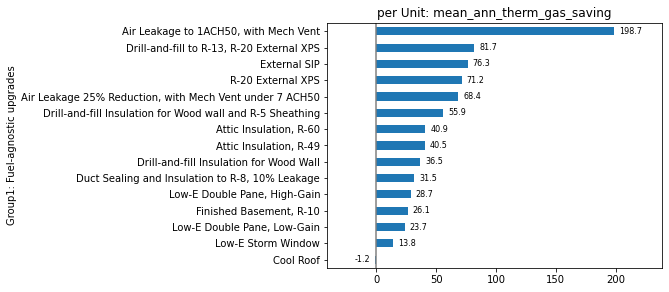

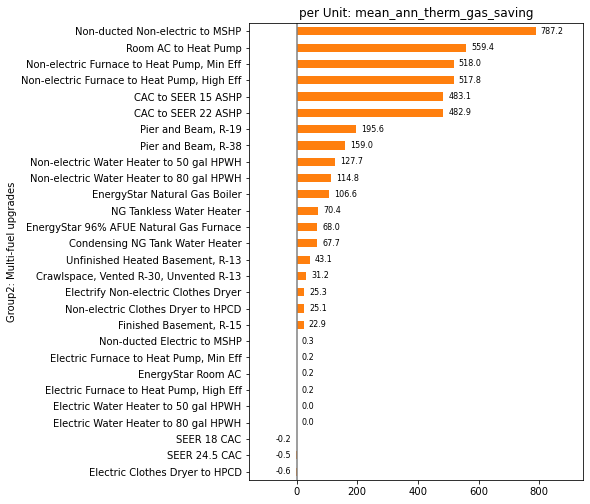

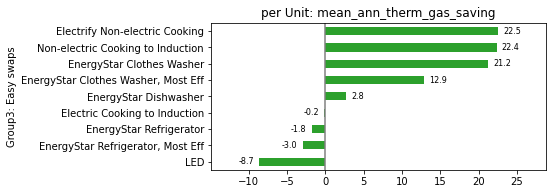

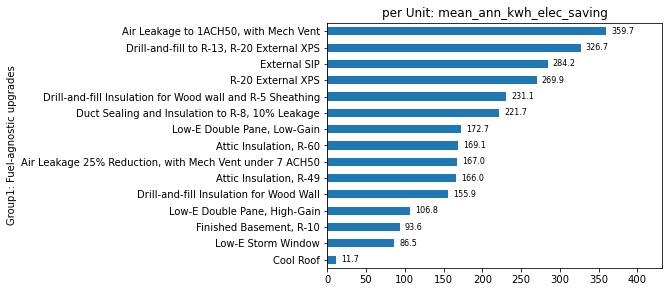

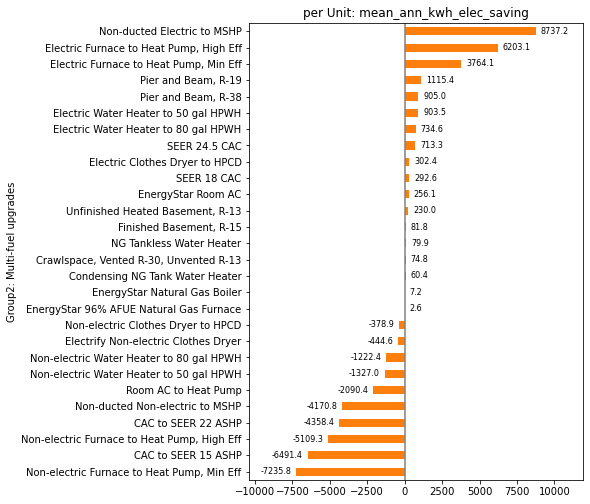

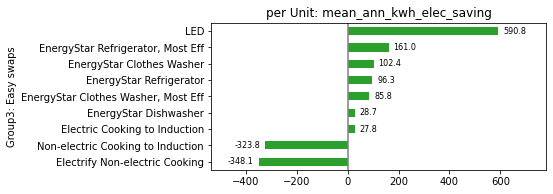

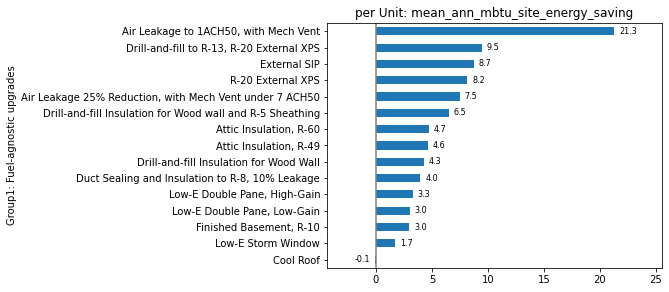

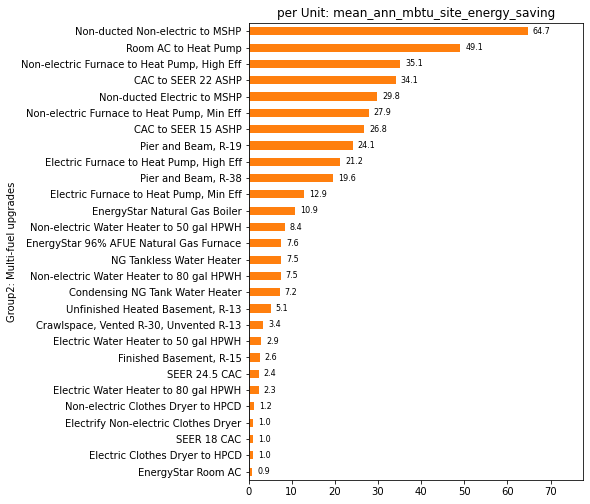

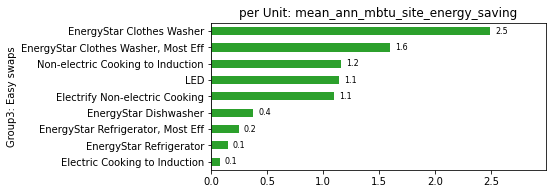

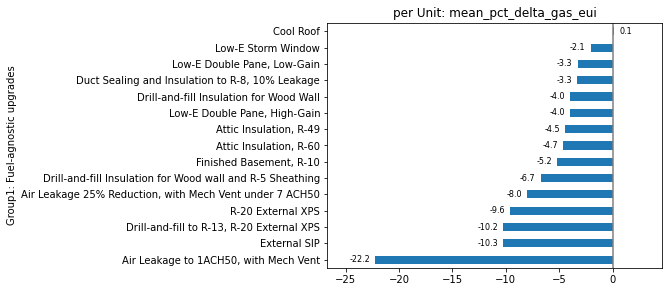

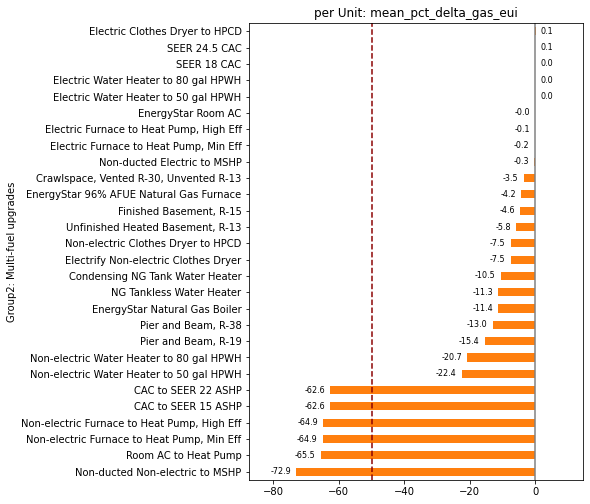

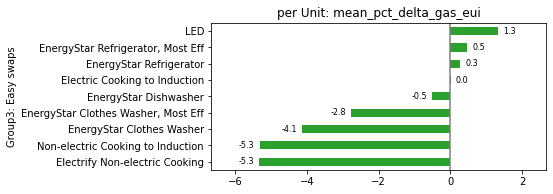

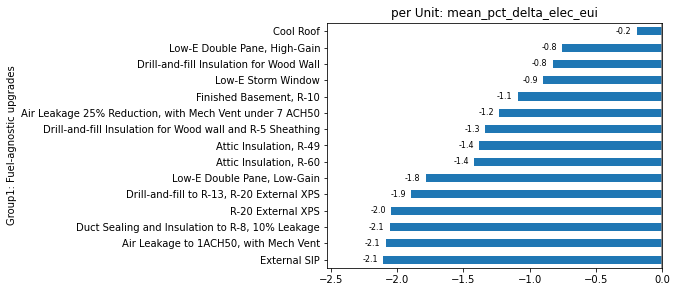

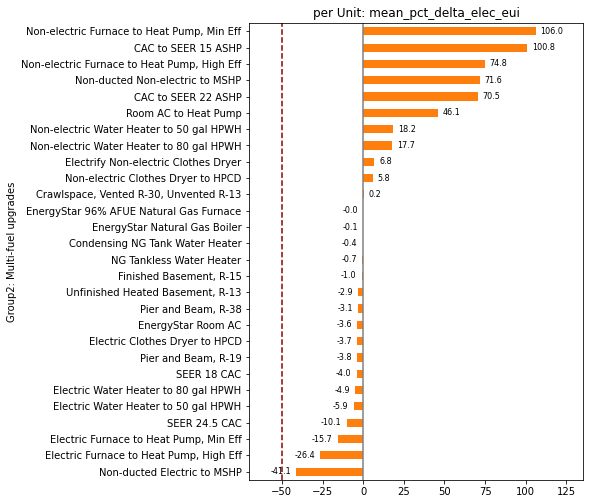

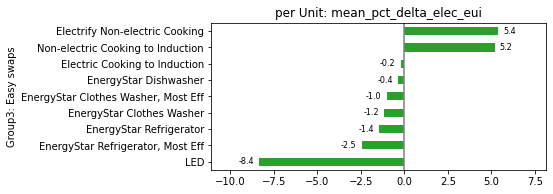

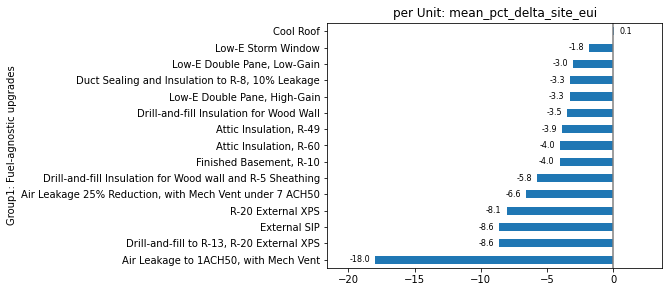

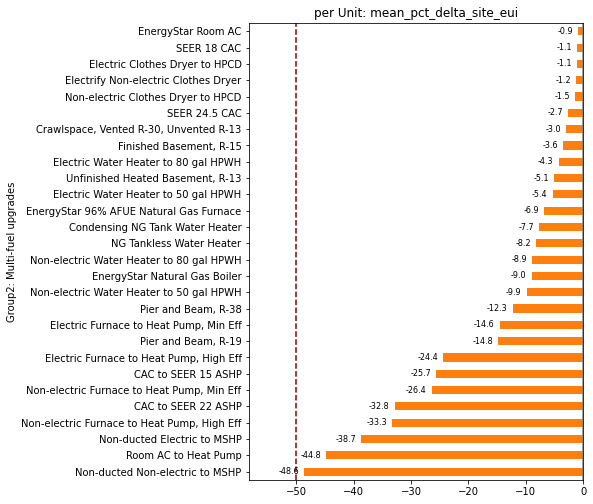

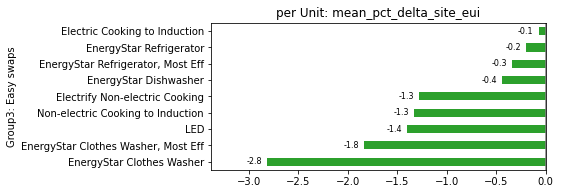

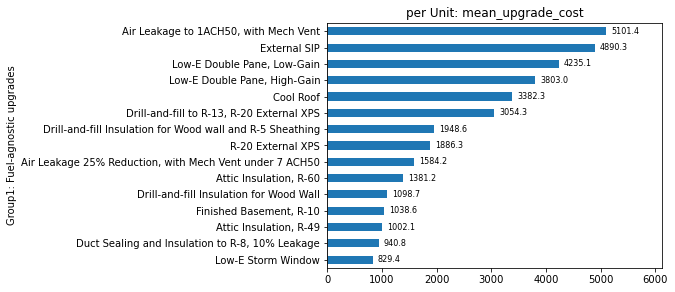

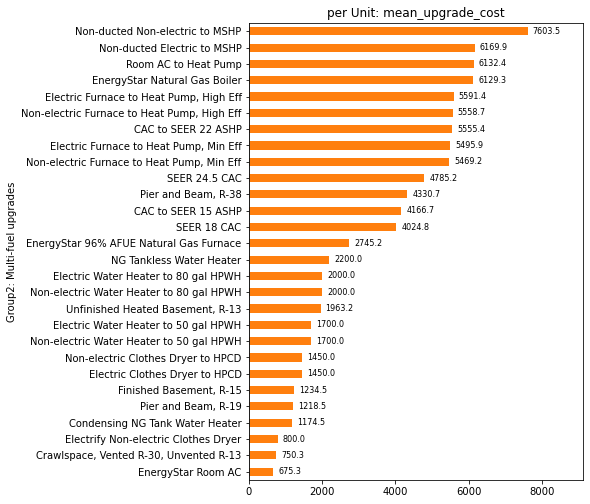

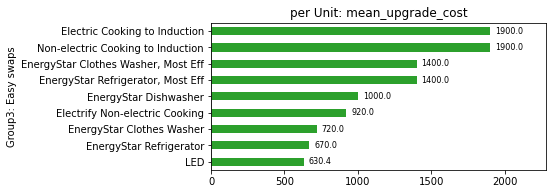

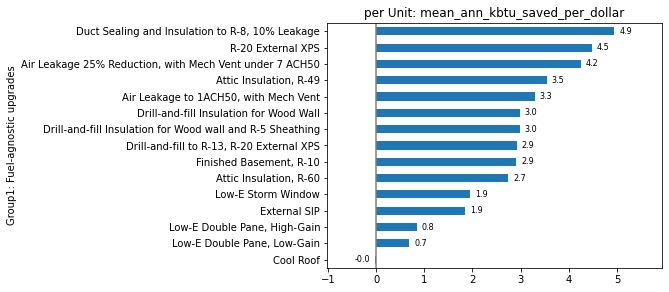

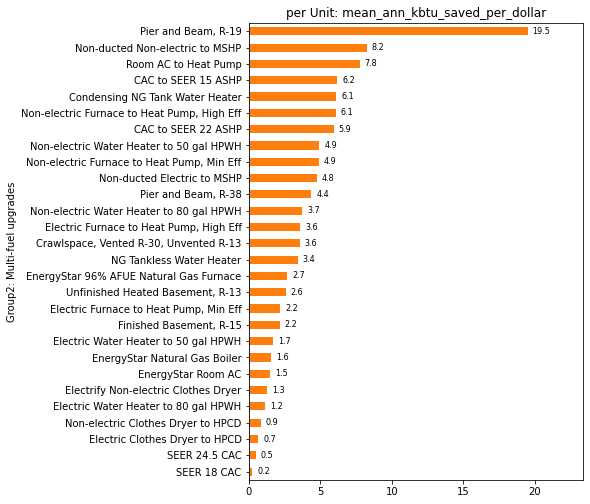

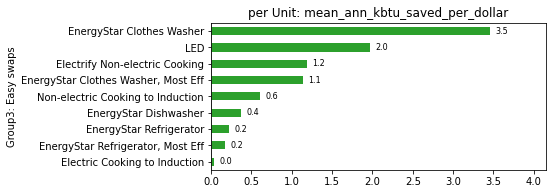

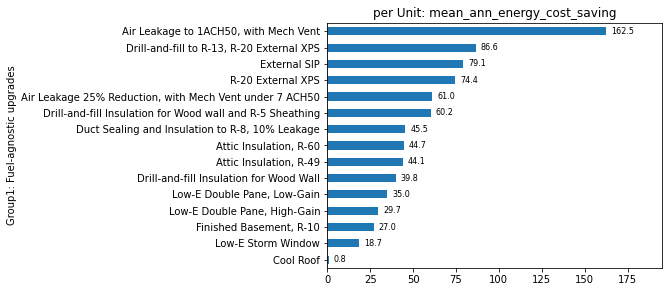

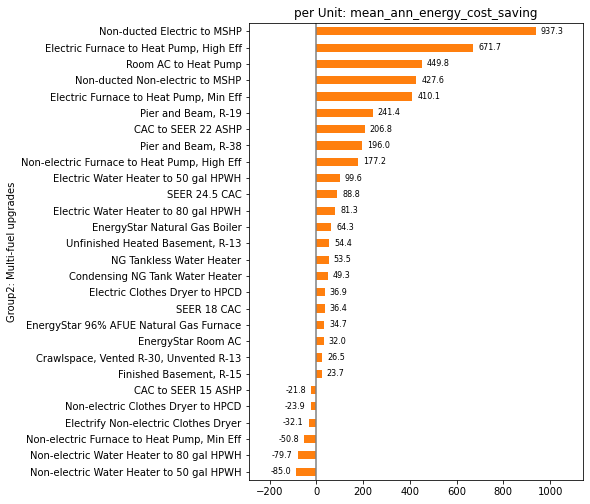

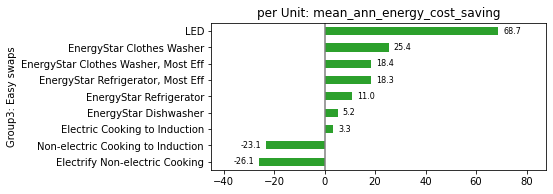

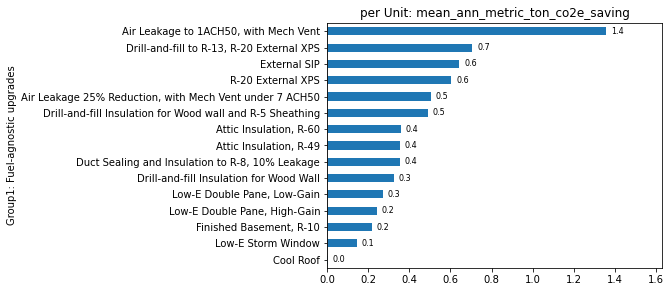

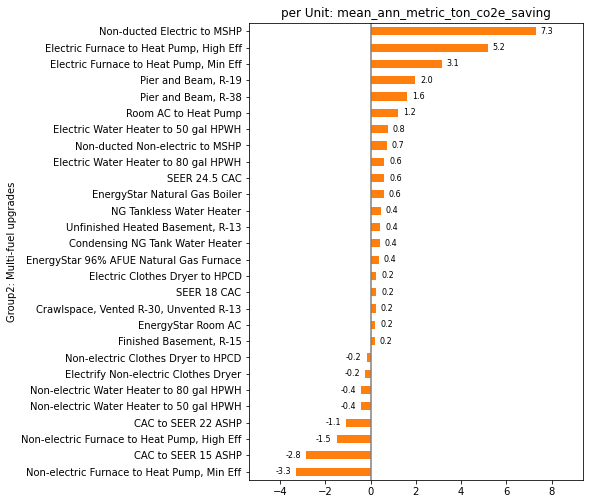

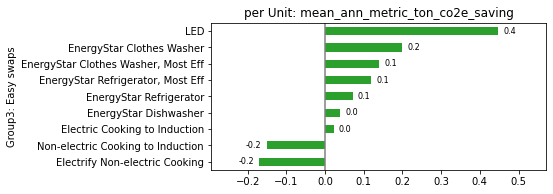

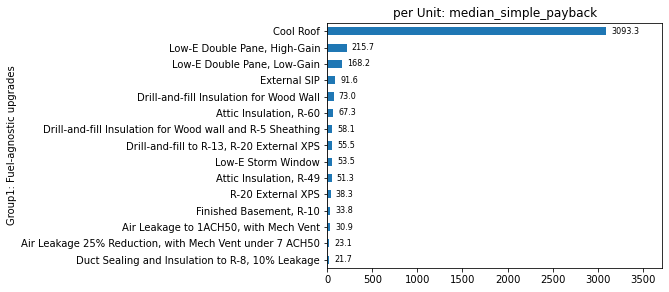

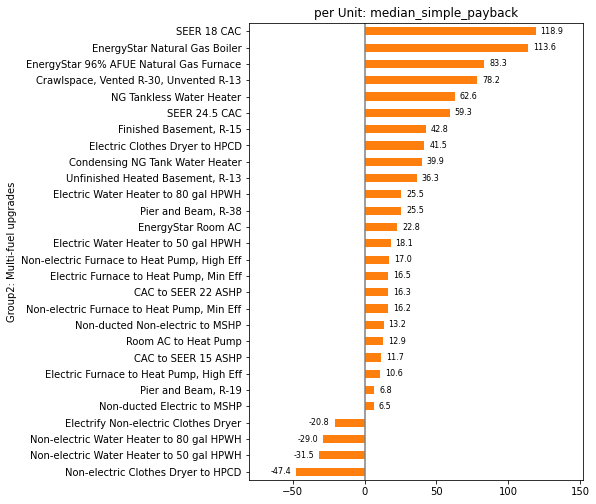

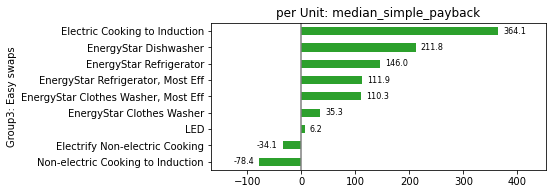

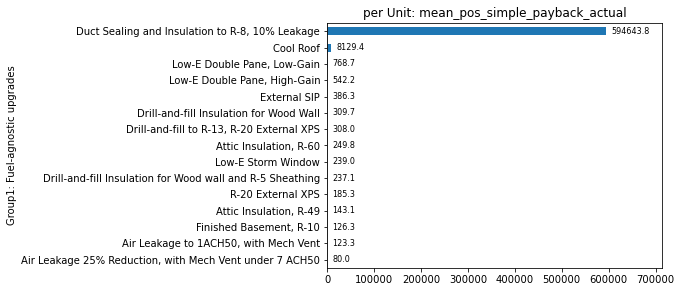

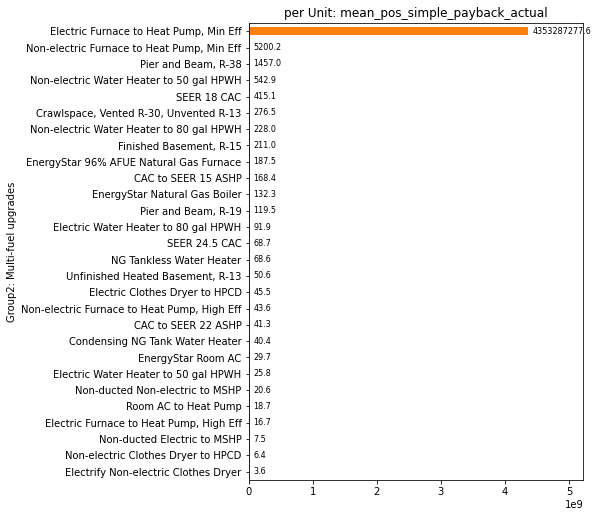

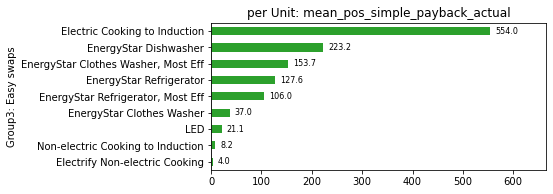

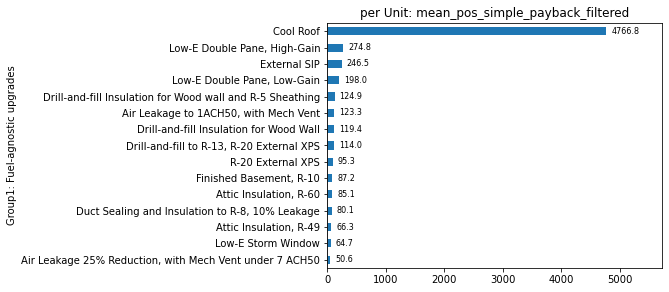

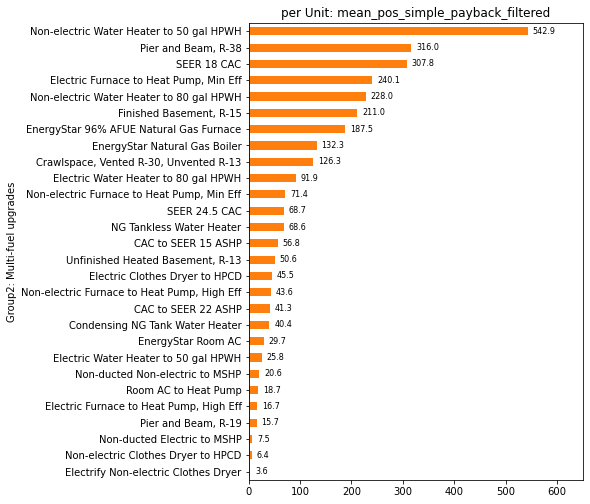

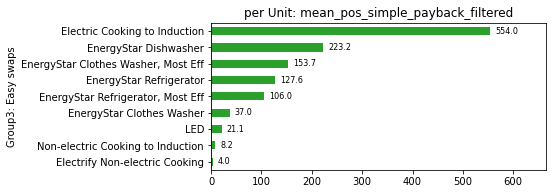

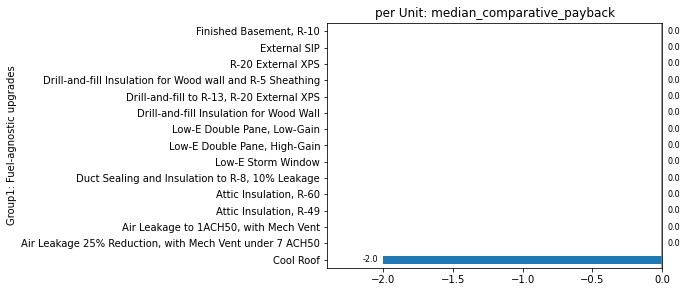

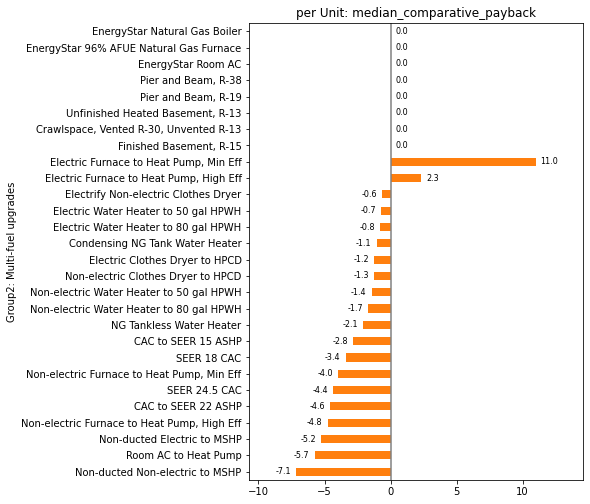

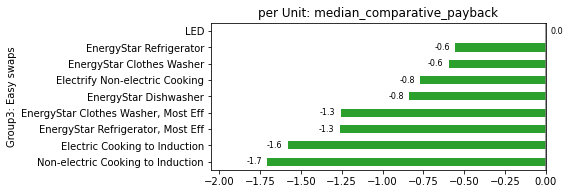

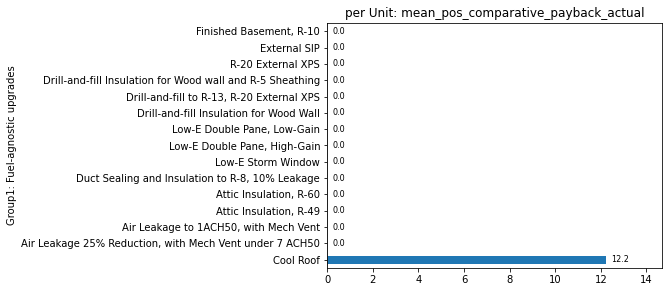

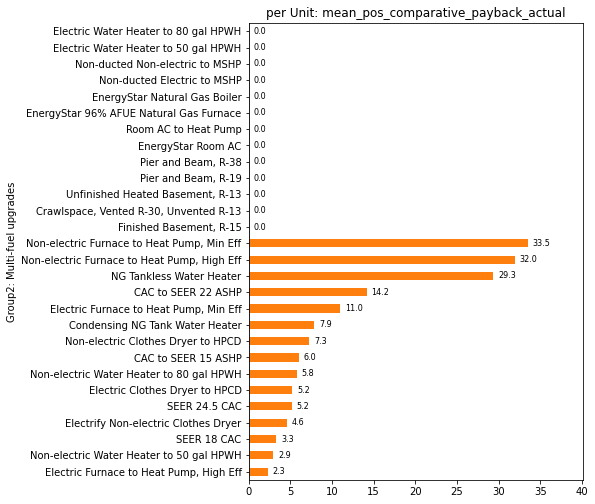

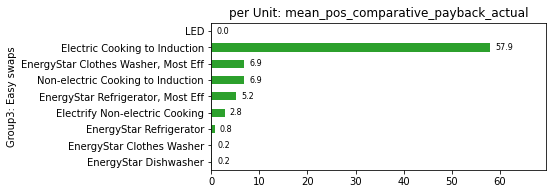

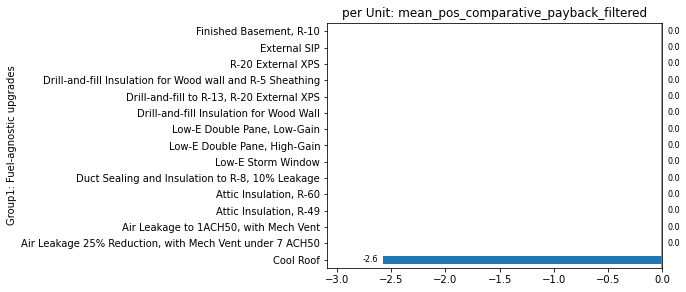

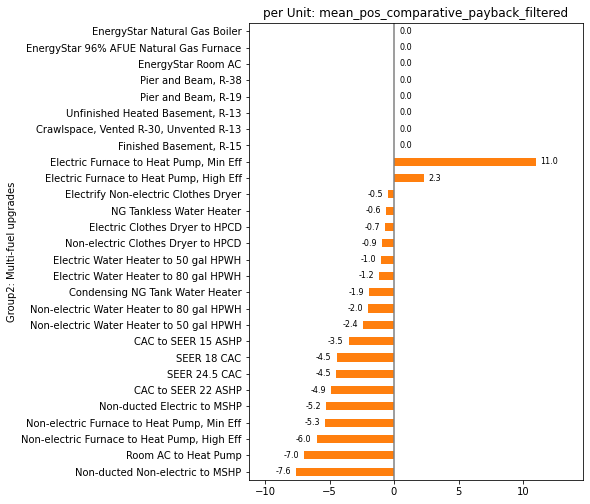

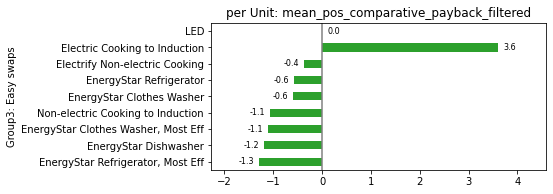

In [50]:
### plot MF-all & MF-2-4 flats (Cook County Avg) ###

summ_ups = summary_upgrades[
    (~summary_upgrades['upgrade_no'].isnull())
     ].reset_index(drop=True)

upgrade_sets = {
    'Group1: Fuel-agnostic upgrades': range(1, 16),
    'Group2: Multi-fuel upgrades': range(16, 44),
    'Group3: Easy swaps': range(44, 53),
}
upgrade_set_colors = {
    'Group1: Fuel-agnostic upgrades': 'tab:blue',
    'Group2: Multi-fuel upgrades': 'tab:orange',
    'Group3: Easy swaps': 'tab:green',
}

# create subfolder for plots:

plot_path5 = os.path.join(plot_path, f'mean_values_sfamh_cook_cnty_avg')
if not os.path.exists(plot_path5):
    os.mkdir(plot_path5)
print(f'plot dir: {plot_path5}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = list(x for x in summary_upgrades.columns if 
                           x.startswith('mean') or x.startswith('median'))
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 
                       'median_simple_payback',
                       'median_comparative_payback',
                       'mean_pos_simple_payback_filtered',
                       'mean_pos_comparative_payback_filtered']

for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'per Unit: {metric}{title_ext}'
    print(f'Plotting {title}...')

    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')

        groupi = summ_ups.loc[
            summ_ups['upgrade_no'].isin(upgrade_sets[up]),
            ['upgrade_name', metric]
        ].set_index(['upgrade_name']).replace([np.inf, -np.inf], np.nan)

        if metric == 'median_comparative_payback':
            groupi = groupi.replace(0,np.nan).sort_values(by = metric) # make 0 nan
        else:
            groupi = groupi.sort_values(by = metric)
        groupi.index.name = up

        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)

        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 

        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')

        filename = f'SFAMH_upgrades_{iteration}_{metric[5:]}_group{n}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path5, filename),
                    bbox_inches='tight')
        